In [2]:
import os
import datetime
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from skimage import filters
from skimage import exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import disk

from scipy.signal import lfilter

In [3]:
#Define path and folder containing tomography cross sections
path = r'D:\Compression -\24-11-10 - CompressionPEMWE\1mm_Bekaert_NR212' #Path where tomographs are stored
folder = 'rec20241110_113352_Test-158_Comp_1mm_Bekaert_NR212_Dry_8bit' #Name of the tomograph to apply the process
imgPath = os.path.join(path, folder)
os.chdir(imgPath)
fileNames = os.listdir(imgPath)
fileNames.sort()
for name in fileNames:
    print(name)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Compression -\\24-11-10 - CompressionPEMWE\\1mm_Bekaert_NR212\\rec20241110_113352_Test-158_Comp_1mm_Bekaert_NR212_Dry_8bit'

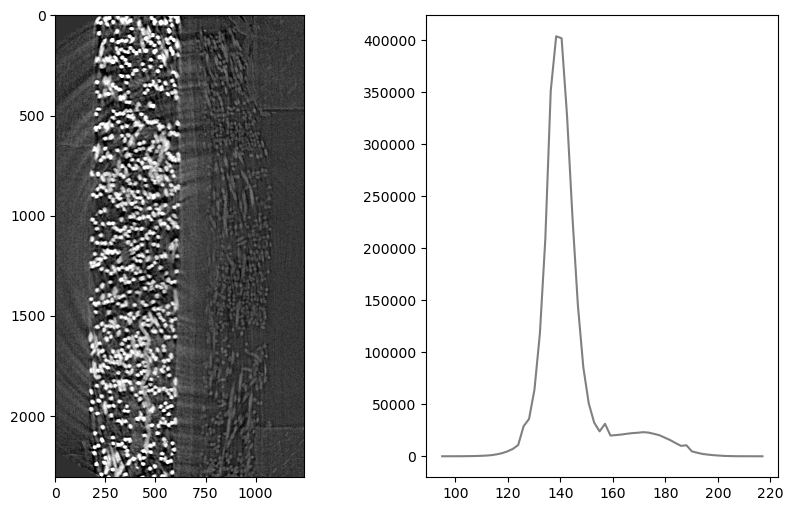

In [11]:
#Display cross section and histogramm
filesNumber = 360 #Index of the image file that will be use to tune parameters 

im = Image.open(imgPath +'/' + fileNames[filesNumber])
im = np.array(im)
counts_att, bins_att = np.histogram(im, bins=60)

fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].imshow(im, cmap='gray', vmin=np.quantile(im, 0.02), vmax=np.quantile(im, 0.98)) #vmin and vmax are used to enhance the contrast of the displayed image
ax[1].plot(bins_att[:-1], counts_att[:], color='grey')

## PTL Segmentation
---

In [1]:
#Crop image and apply filters
#---------------
minX_PTL, maxX_PTL = 80, 680 #Index of the first and last pixel to crop the image on the x axis
minY_PTL, maxY_PTL = 0, 2560 #Index of the first and last pixel to crop the image on the y axis
shape_PTL = disk(radius=1)   #Set the size for the median filter, function filters.rank.median
cutoff, gain, inv = 0.6, 10, False #Parameter to enhance contrast, function exposure.adjust_sigmoid
#----------------
fig, ax = plt.subplots(1,3, figsize=(10, 6))
#Original Image
imPTL = im[minY_PTL:maxY_PTL, minX_PTL:maxX_PTL]
ax[0].imshow(imPTL, cmap='gray', vmin=np.quantile(imPTL, 0.02), vmax=np.quantile(imPTL, 0.98))
ax[0].set_title('Original')
imPTL = filters.rank.median(imPTL, shape_PTL) #
imPTL = exposure.adjust_sigmoid(imPTL, cutoff=cutoff, gain=gain, inv=inv) #Enhance contrast
#Median filter and contrast enhancement
ax[1].imshow(imPTL, cmap='gray', vmin=np.quantile(imPTL, 0.02), vmax=np.quantile(imPTL, 0.98))
ax[1].set_title('Median filter')
#Histogramm
counts_att, bins_att = np.histogram(imPTL, bins=50)
ax[2].plot(bins_att[:-1], counts_att[:], color='grey')
ax[2].set_title('Histogramm')

NameError: name 'disk' is not defined

(<Figure size 600x1200 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

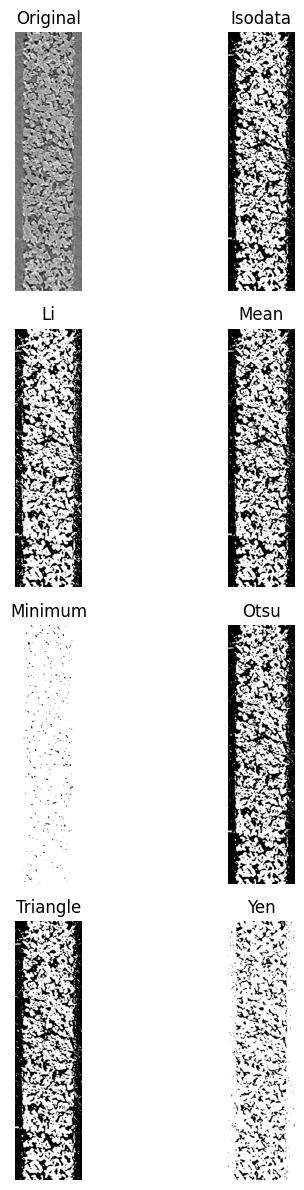

In [17]:
filters.try_all_threshold(imPTL, figsize=(6, 12), verbose=False)

147


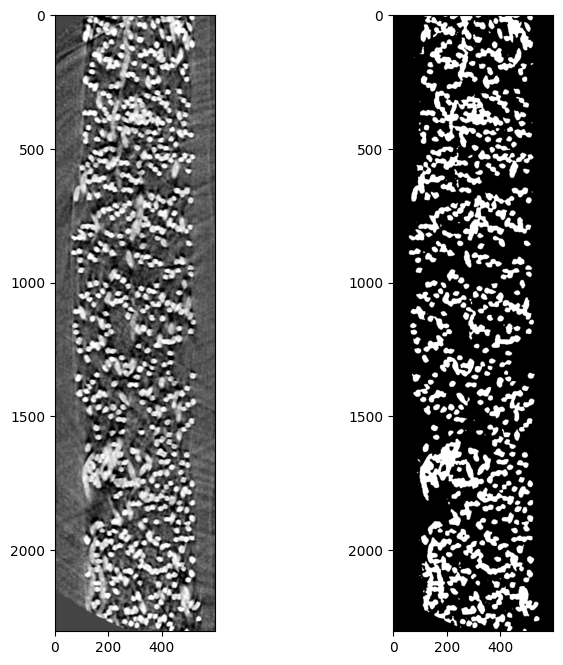

In [386]:
#Threshold image
#----------
thresh = filters.threshold_otsu(imPTL) #Change the function according to the threshold method you need
#----------

print('Threshold pixel value:', thresh)
imPTL_thresh = imPTL > thresh
fig, ax = plt.subplots(1,2 , figsize=(8,8))
ax[0].imshow(imPTL, cmap='gray', vmin=np.quantile(imPTL, 0.02), vmax=np.quantile(imPTL, 0.98))
ax[1].imshow(imPTL_thresh, cmap='gray')

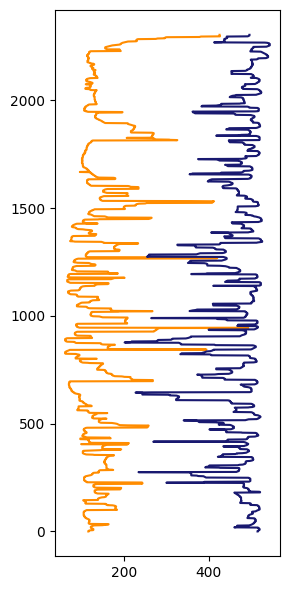

In [387]:
#Detect the position of the first and last PTL particles
#----------
pixN_PTL = 5 #Number of consecutives pixels to encounter
#----------

first_ind, last_ind = [], []
for line in imPTL_thresh:
    ind_list = []
    ind=0
    for px in line:
        if px == 1:
            ind_list.append(ind)
        ind += 1
    #Return x index of the first pixel
    cnt=0
    prv = 0
    for i in ind_list[1:]:
        if i - prv == 1:
            cnt = cnt + 1
        else:
            cnt = 0
        if cnt == pixN_PTL:
            break
        prv = i
    first = i-cnt
    #Return x index of the last pixel
    cnt=0
    prv = 0
    for i in reversed(ind_list[:]):
        if prv-i  == 1:
            cnt = cnt + 1
        else:
            cnt = 0
        if cnt == pixN_PTL:
            break
        prv = i
    last = i+cnt
    first_ind.append(first)
    last_ind.append(last)

fig, ax = plt.subplots(figsize=(3,6))
ax.plot(first_ind, np.linspace(0, len(first_ind), len(first_ind)), label='Channel side', c='darkorange')
ax.plot(last_ind, np.linspace(0, len(first_ind), len(first_ind)), label='Membrane side', c='midnightblue')
fig.tight_layout()

## GDL Segmentation


Text(0.5, 1.0, 'Median filter')

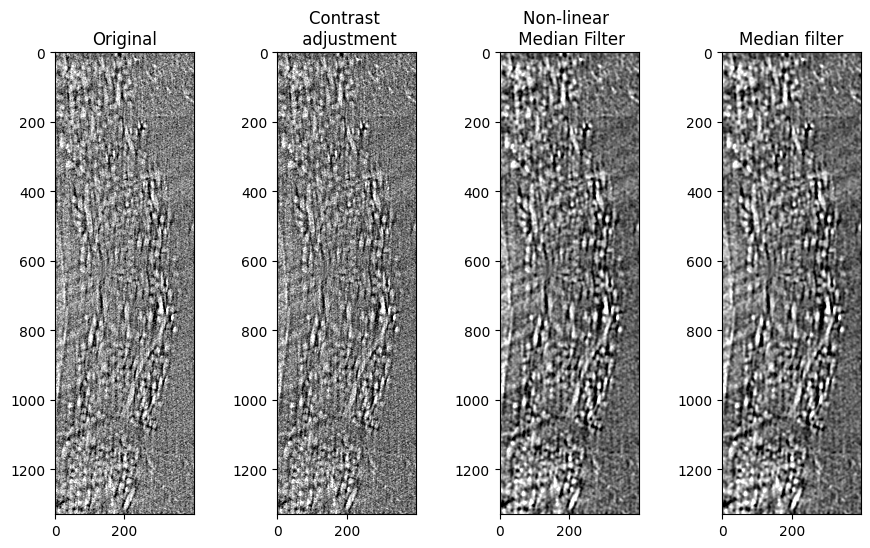

In [404]:
#Crop images and apply filters
#-----------
minX_GDL, maxX_GDL = 690, 1090         #Index of the first and last pixel to crop the image on the x axis
minY_GDL, maxY_GDL = 480, 1810         #Index of the first and last pixel to crop the image on the y axis
shape_GDL = disk(radius=1)             #Set the size for the median filter, function filters.rank.median
cutoff, gain, inv = 0.6, 10, False     #Parameters to enhance contrast, function exposure.adjust_sigmoid
patch_size, patch_distance, h, coeffSigma = 3, 3, 5, 5 #Parameters to denoise the image, function denoise_nl_means
#-----------

imGDL = im[minY_GDL:maxY_GDL, minX_GDL:maxX_GDL]
fig, ax = plt.subplots(1,4, figsize=(11, 6))
ax[0].imshow(imGDL, cmap='gray', vmin=np.quantile(imGDL, 0.02), vmax=np.quantile(imGDL, 0.98))
ax[0].set_title('Original')

# Tune image exposure
imGDL = exposure.adjust_sigmoid(imGDL, cutoff=cutoff, gain=gain, inv=inv)
ax[1].imshow(imGDL, cmap='gray', vmin=np.quantile(imGDL, 0.02), vmax=np.quantile(imGDL, 0.98))
ax[1].set_title('Contrast \n adjustment')

# Denoising non linear median filter
sigma = np.mean(estimate_sigma(imGDL))
imGDL = denoise_nl_means(imGDL, patch_size=patch_size, patch_distance=patch_distance, h=h, 
                         fast_mode=False, sigma=sigma, preserve_range=False, channel_axis=None)

ax[2].imshow(imGDL, cmap='gray', vmin=np.quantile(imGDL, 0.02), vmax=np.quantile(imGDL, 0.98))
ax[2].set_title('Non-linear \n Median Filter')

#Median filter
imGDL = filters.median(imGDL, shape_GDL)
ax[3].imshow(imGDL, cmap='gray', vmin=np.quantile(imGDL, 0.02), vmax=np.quantile(imGDL, 0.98)) 
ax[3].set_title('Median filter')

(<Figure size 600x1200 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

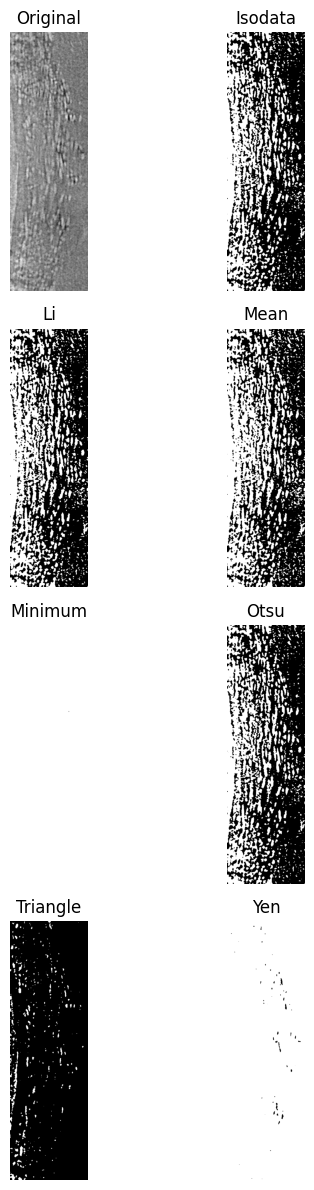

In [398]:
filters.try_all_threshold(imGDL, figsize=(6, 12), verbose=False)

Threshold: 0.24483274559823925


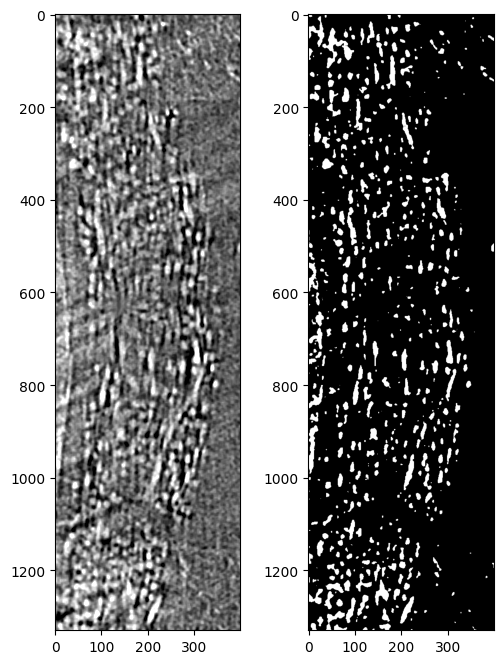

In [405]:
#Threshold image
#-----------
thresh = filters.threshold_yen(imGDL)
#-----------
print('Threshold:', thresh)
imGDL_thresh = imGDL > thresh

fig, ax = plt.subplots(1,2 , figsize=(6,8)) 
ax[0].imshow(imGDL, cmap='gray', vmin=np.quantile(imGDL, 0.02), vmax=np.quantile(imGDL, 0.98))
ax[1].imshow(imGDL_thresh, cmap='gray')

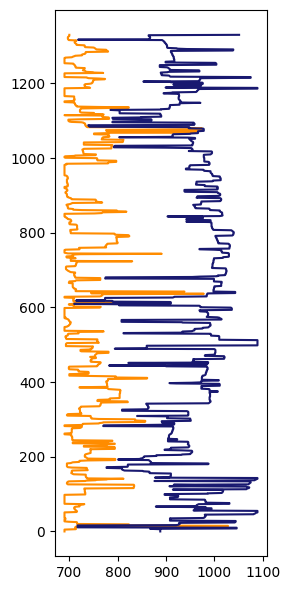

In [406]:
#Detect the position of the first and last GDL particles
#-----------
pixN_GDL = 3 #Number of consecutives pixels to encounter
#-----------

first_ind, last_ind = [], []
for line in imGDL_thresh:
    ind_list = []
    ind=0
    for px in line:
        if px == 1:
            ind_list.append(ind)
        ind += 1
    #Return x index of the first pixel
    cnt=0
    prv = 0
    for i in ind_list[1:]:
        if i - prv == 1:
            cnt = cnt + 1
        else:
            cnt = 0
        if cnt == pixN_GDL:
            break
        prv = i
    first_ind.append(i-cnt)
    #Return x index of the last pixel
    cnt=0
    prv = 0
    for i in reversed(ind_list[:]):
        if prv-i  == 1:
            cnt = cnt + 1
        else:
            cnt = 0
        if cnt == pixN_GDL:
            break
        prv = i
    last_ind.append(i+cnt)

fig, ax = plt.subplots(figsize=(3,6))
ax.plot(np.array(first_ind)+minX_GDL, np.linspace(0, len(first_ind), len(first_ind)), label='Channel side', c='darkorange')
ax.plot(np.array(last_ind)+minX_GDL, np.linspace(0, len(first_ind), len(first_ind)), label='Membrane side', c='midnightblue')
fig.tight_layout()

## Sequential process
___

In [407]:
#----------
imgPath 
outputFileName = '0p65mm_Bekaert_NR212_17Ncm' 
outputFolder = '1- Analysis'
#----------

outputPath = os.path.join(path, outputFolder)
fileNames = os.listdir(imgPath)
if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    
print('Files:\n', fileNames[0],'...', fileNames[-1])
df = pd.DataFrame({'PTL':[[minX_PTL, maxX_PTL], [minY_PTL, maxY_PTL], None, None, int((np.shape(shape_PTL)[0]-1)/2), pixN_PTL],
                   'GDL':[[minX_GDL, maxX_GDL], [minY_GDL, maxY_GDL], [cutoff, gain, inv], [patch_size, patch_distance, h, coeffSigma], 
                          int((np.shape(shape_GDL)[0]-1)/2), pixN_GDL],},
                 index = ['x limits', 'y limits', 'Expsure filter', 'NL median', 'Median', 'Pixels counts'])
print('Following parameters will be applied for data processing:')
df

Files:
 rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00000.tif ... rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00719.tif


,PTL,GDL
x limits,"[80, 680]","[690, 1090]"
y limits,"[0, 2560]","[480, 1810]"
Expsure filter,None,"[0.7, 10, False]"
NL median,None,"[3, 3, 5, 5]"
Median,4,2
Pixels counts,5,3


In [408]:
#----------
start, stop = 0, 1000 #Downselect the images to proceed
slc = 0 + start 
#----------

fileNames = fileNames[start: stop]
for image in fileNames:
    pos_PTL_first, pos_PTL_last = [],[]
    pos_GDL_first, pos_GDL_last = [],[]
    now = datetime.datetime.now()
    t = str(now.time())[:8]
    print(t, ':', image)
    im = Image.open(imgPath +'/' + image)
    im = np.array(im)

#--- Processing PTL ----
    imPTL = im[minY_GDL:maxY_GDL,minX_PTL:maxX_PTL] #Delimit PTL 
    imPTL = filters.rank.median(imPTL, shape_PTL) #Apply median filter
    thresh = filters.threshold_otsu(imPTL) #Threshold the image
    imPTL_thresh = imPTL > thresh
    
    #Determine first and last pixels over the height
    first_ind, last_ind = [], []
    for line in imPTL_thresh:
        ind_list = []
        ind=0
        for px in line:
            if px == 1:
                ind_list.append(ind)
            ind += 1
        #Return x index of the first pixel
        cnt=0
        prv = 0
        for i in ind_list[1:]:
            if i - prv == 1:
                cnt = cnt + 1
            else:
                cnt = 0
            if cnt == pixN_PTL:
                break
            prv = i
        first = i-cnt
        #Return x index of the last pixel
        cnt=0
        prv = 0
        for i in reversed(ind_list[:]):
            if prv-i  == 1:
                cnt = cnt + 1
            else:
                cnt = 0
            if cnt == pixN_PTL:
                break
            prv = i
        last = i+cnt
        first_ind.append(first)
        last_ind.append(last)
    pos_PTL_first = [slc] + first_ind
    pos_PTL_last = [slc] + last_ind
    
#--- Processing GDL ---
    imGDL = im[minY_GDL:maxY_GDL, minX_GDL:maxX_GDL] #Delimit GDL
    imGDL = exposure.adjust_sigmoid(imGDL, cutoff=cutoff, gain=gain, inv=inv) #Tune contrast
    sigma = np.mean(estimate_sigma(imGDL)) #Non-linear median filter
    imGDL = denoise_nl_means(imGDL, patch_size=patch_size, patch_distance=patch_distance, h=h, fast_mode=True, sigma=sigma, 
                          preserve_range=True, channel_axis=None) 
    imGDL = filters.median(imGDL, shape_GDL) #Median filter

    thresh = filters.threshold_yen(imGDL) #Thresh
    imGDL_thresh = imGDL > thresh

    #Determine first and last pixels over the height
    first_ind, last_ind = [], []
    for line in imGDL_thresh:
        ind_list = []
        ind = 0
        for px in line:
            if px == 1:
                ind_list.append(ind)
            ind += 1
        #Return x index of the first pixel
        cnt=0
        prv = 0
        for i in ind_list[1:]:
            if i - prv == 1:
                cnt = cnt + 1
            else:
                cnt = 0
            if cnt == pixN_GDL:
                break
            prv = i
        first_ind.append(i-cnt+minX_GDL)
        #Return x index of the last pixel
        cnt=0
        prv = 0
        for i in reversed(ind_list[:]):
            if prv-i  == 1:
                cnt = cnt + 1
            else:
                cnt = 0
            if cnt == pixN_GDL:
                break
            prv = i
        last_ind.append(i+cnt+minX_GDL)
    pos_GDL_first = [slc] + first_ind
    pos_GDL_last = [slc] + last_ind

    #--- Saving the position of the GDL edges and PTL edges relatively to the image start
    os.chdir(outputPath)
    with open(str(outputFileName + '_GDL_first.csv'), "a") as outfile:
        outfile.write(str(pos_GDL_first)[1:-1])
        outfile.write('\n')
    with open(str(outputFileName + '_GDL_last.csv'), "a") as outfile:
        outfile.write(str(pos_GDL_last)[1:-1])
        outfile.write('\n')
    with open(str(outputFileName + '_PTL_first.csv'), "a") as outfile:
        outfile.write(str(pos_PTL_first)[1:-1])
        outfile.write('\n')
    with open(str(outputFileName + '_PTL_last.csv'), "a") as outfile:
        outfile.write(str(pos_PTL_last)[1:-1])
        outfile.write('\n')
    slc += 1 

print('------- Files Saved -------')

08:38:24 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00000.tif
08:38:27 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00001.tif
08:38:30 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00002.tif
08:38:33 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00003.tif
08:38:36 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00004.tif
08:38:39 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00005.tif
08:38:43 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00006.tif
08:38:46 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00007.tif
08:38:49 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00008.tif
08:38:52 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00009.tif
08:38:55 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_17Ncm_8bit00010.tif
08:38:58 : rec20241110_105904_Test-157_Comp_0p65mm_Bekaert_NR212_

## Membrane segmentation
---
Tried with local threshold method, doesn't work

Sigma denoising:   1.05E+00


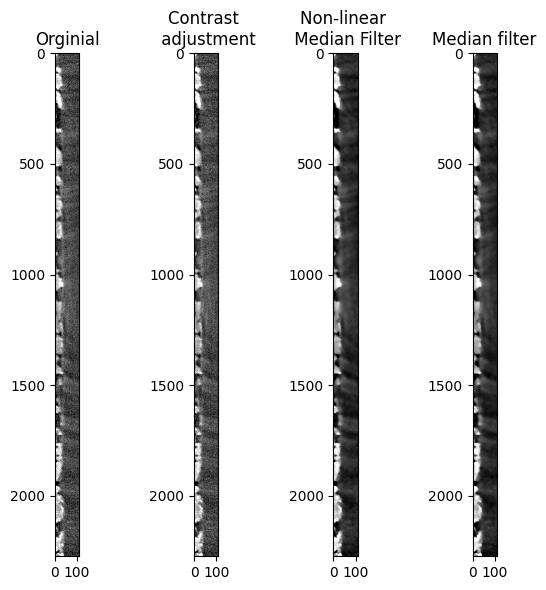

In [425]:
minX, maxX = 490, 600
imMemb = im[:,minX:maxX]
shape_Memb = disk(radius=2)

fig, ax = plt.subplots(1,4, figsize=(6,6))
ax[0].imshow(imMemb, cmap='gray', vmin=np.quantile(imMemb, 0.02), vmax=np.quantile(imMemb, 0.98))
ax[0].set_title('Orginial')

# Tune image exposure
cutoff, gain, inv = 0.5, 5, False
imMemb = exposure.adjust_sigmoid(imMemb, cutoff=cutoff, gain=gain, inv=inv)
ax[1].imshow(imMemb, cmap='gray', vmin=np.quantile(imMemb, 0.02), vmax=np.quantile(imMemb, 0.98))
ax[1].set_title('Contrast \n adjustment')

#Denoising non linear median filter
patch_size, patch_distance, h, coeffSigma = 5, 10, 5, 1 #Denoising parameters
sigma = np.mean(estimate_sigma(imMemb))
print('Sigma denoising:', "%10.2E" % sigma)
imMemb = denoise_nl_means(imMemb, patch_size=patch_size, patch_distance=patch_distance, h=h, fast_mode=True, sigma=sigma, 
                          preserve_range=True, channel_axis=None)
ax[2].imshow(imMemb, cmap='gray', vmin=np.quantile(imMemb, 0.02), vmax=np.quantile(imMemb, 0.98))
ax[2].set_title('Non-linear \n Median Filter')

#Median filter
imMemb = filters.median(imMemb, shape_Memb)
ax[3].imshow(imMemb, cmap='gray', vmin=np.quantile(imMemb, 0.02), vmax=np.quantile(imMemb, 0.98)) 
ax[3].set_title('Median filter')

fig.tight_layout()

(<Figure size 600x1000 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

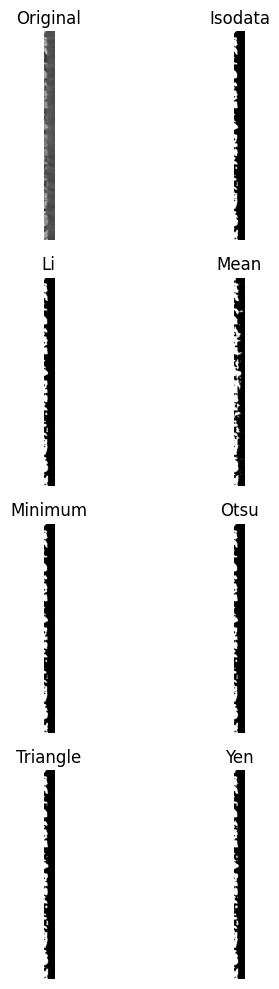

In [426]:
filters.try_all_threshold(imMemb, figsize=(6, 10), verbose=False)

[121.68148434 129.81018216]


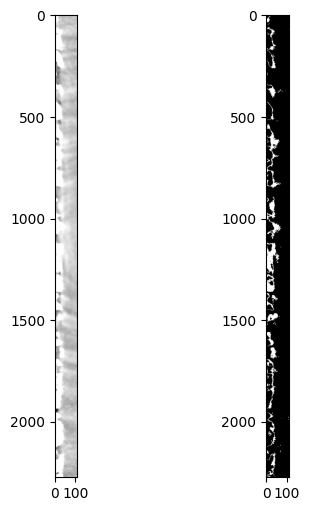

In [427]:
# fig, ax = plt.subplots(1,2, figsize=(6, 12))
thresh = filters.threshold_multiotsu(imMemb)
print(thresh)
imMemb_threshLow = imMemb < thresh[0]
imMemb_threshMed = ((imMemb > thresh[0]) & (imMemb < thresh[1]))

thresh = filters.threshold_yen(imMemb)
imMemb_threshLow = np.clip(imMemb, 0, thresh)

fig, ax = plt.subplots(1,2, figsize=(5,6))
ax[0].imshow(imMemb_threshLow, cmap='gray')
ax[1].imshow(imMemb_threshMed, cmap='gray')